<a href="https://colab.research.google.com/github/viththiananth/20221015-Convolutional-Neural-Network-on-Flower-Dataset/blob/main/Convolutional_Neural_Network_on_Flower_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [14]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [5]:
import os
print(os.listdir())

['.config', 'sample_data']


In [8]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='E:\\2.1. Datascience HNDA\\5. Deep Learning\\7. Assingnement_CNN for flowers\\Data Set\\flowers\\daisy'
FLOWER_DANDI_DIR='E:\\2.1. Datascience HNDA\\5. Deep Learning\\7. Assingnement_CNN for flowers\\Data Set\\flowers\\dandelion'
FLOWER_ROSE_DIR='E:\\2.1. Datascience HNDA\\5. Deep Learning\\7. Assingnement_CNN for flowers\\Data Set\\flowers\\rose'
FLOWER_SUNFLOWER_DIR='E:\\2.1. Datascience HNDA\\5. Deep Learning\\7. Assingnement_CNN for flowers\\Data Set\\flowers\\sunflower'
FLOWER_TULIP_DIR='E:\\2.1. Datascience HNDA\\5. Deep Learning\\7. Assingnement_CNN for flowers\\Data Set\\flowers\\tulip'

In [10]:
def assign_label(img,flower_type):
    return flower_type

In [11]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [13]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

FileNotFoundError: ignored

IndexError: ignored

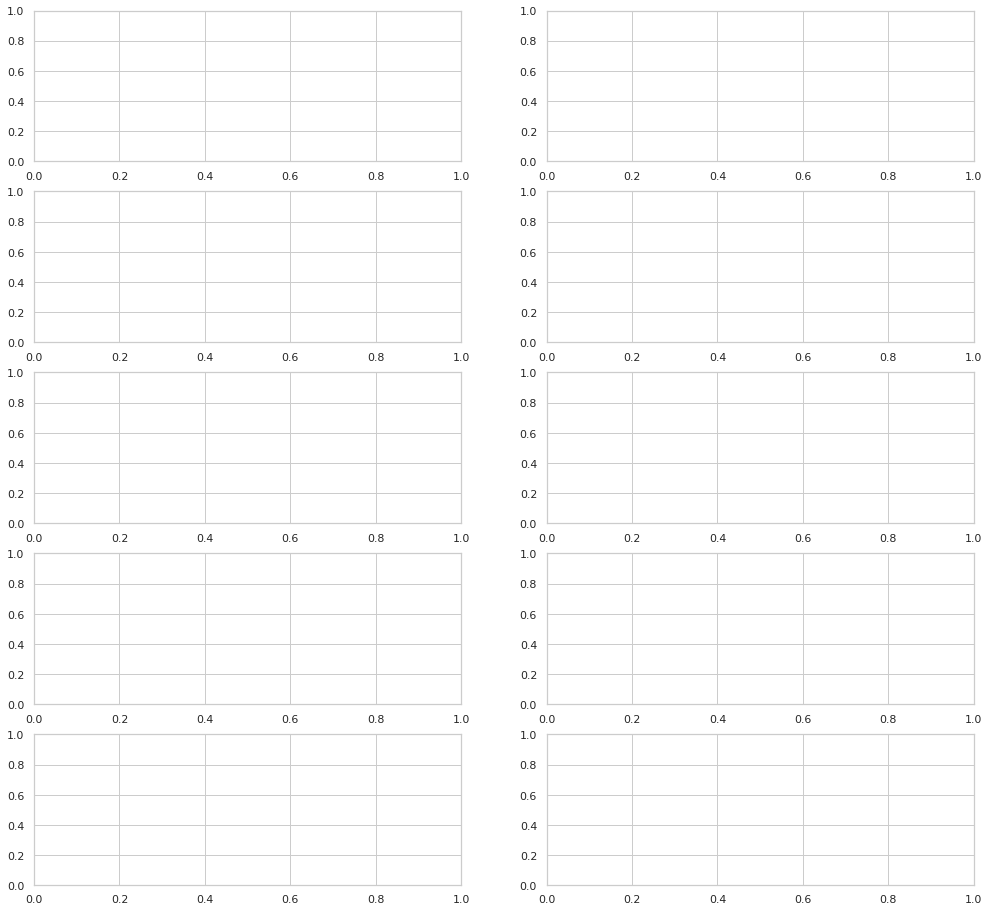

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [ ]:
a